# Google Colab setup with Google Drive folder

This notebook provides the code you need to set up Google Colab to run and import files from within a Google Drive folder.

This will allow you to upload assignment code to your Google Drive and then run the code on Google Colab machines (with free GPUs if needed).

You will need to create a folder in your Google Drive to hold your assignments and you will need to open Colaboratory within this folder before running the set up code (check the link above to see how).

Note: this use of Google Drive is optional, and you could also just manually copy the data into your colab runtime. Keep in mind, this won't be persistent though, and you will have to download your models / plots before the runtime shuts down.

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You will be asked to copy and paste an authentication code.

In [1]:
COLAB = True
if COLAB:
    from google.colab import drive
    drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder).

In [3]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
if COLAB:
    work_dir = "/content/drive/MyDrive/CS444/549_mp5/"
else:
    work_dir = "/home/changl25/private/assignment4/"
if not os.path.exists(work_dir) and COLAB:
  !ln -s "/content/drive/MyDrive/CS444/assignment4/" $work_dir # TODO: Fill your Assignment 3 path
os.chdir(work_dir)
!pwd

/content/drive/MyDrive/CS444/549_mp5


In [4]:
!ls # Check if this is your MP4 folder

CS543_MP5_part1_starter_code.ipynb  model			 seg_model
CS543_MP5_part1_starter_code.py     mp4_q1_plot.png		 val_plot_bst.png
CS543_MP5_part1_starter_code.txt    Q1_label_predictions.npy	 val_plot.png
CS543_MP5_part2_starter_code.ipynb  Q2_ori_sseg_predictions.npy  vis
CS543_MP5_part2_starter_code.py     Q2_sseg_predictions_bst.npy  vis_trainset.pdf
data				    Q2_sseg_predictions.npy	 vis_trainset.png


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [5]:
# !pip3 install torch torchvision

Make sure that pytorch is installed and works with GPU:

In [6]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [7]:
torch.cuda.is_available()

True

In [8]:
# imports and useful functions

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import copy
import csv
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
from tqdm.notebook import tqdm
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


class CIFAR10Test(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None,
    ):
        super(CIFAR10Test, self).__init__(root, transform=transform)

        image_filename = os.path.join(root, 'cifar10_secret_test_data.npy')
        images = np.load(image_filename)

        assert len(images.shape) == 4
        assert images.shape[0] == 2000
        assert images.shape[1] == 32
        assert images.shape[2] == 32
        assert images.shape[3] == 3

        self.data = images

    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.data)


def calculate_accuracy(dataloader, model, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        dataloader (torch.utils.data.DataLoader): val set
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    # Check out why .eval() is important!
    # https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
    model.eval()

    with torch.no_grad():
      for data in dataloader:
          images, labels = data
          if is_gpu:
              images = images.cuda()
              labels = labels.cuda()
          outputs = model(Variable(images))
          _, predicted = torch.max(outputs.data, 1)
          predictions.extend(list(predicted.cpu().numpy()))
          total += labels.size(0)
          correct += (predicted == labels).sum().cpu().numpy()

          c = (predicted == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].cpu().numpy()
              class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy


def run_secret_test(dataloader, model, is_gpu):
    predictions = []
    model.eval()

    with torch.no_grad():
      for images in dataloader:
          if is_gpu:
              images = images.cuda()
          outputs = model(Variable(images))
          predicted = torch.softmax(outputs, dim=1).cpu().numpy()
          predictions.extend(list(predicted))

    return predictions



Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the randomized CIFAR10 training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .npy file for submission to Gradescope

In [9]:
# <<TODO>>: Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
EPOCHS = 100
# ---------

IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 10
TRAIN_BS = 128
PATH_TO_CIFAR10 = "data/cifar10/"
PATH_TO_CIFAR10_TEST = "data/cifar10-test/"

In [10]:
if not os.path.isfile(os.path.join(PATH_TO_CIFAR10_TEST, 'cifar10_secret_test_data.npy')):
  %pip install -U gdown
  import gdown
  url = "https://drive.google.com/uc?id=1ZbiifeCthzaisx9op0tFTlx2dbQsjuwU"
  os.makedirs(PATH_TO_CIFAR10_TEST)
  output = os.path.join(PATH_TO_CIFAR10_TEST, 'cifar10_secret_test_data.npy')
  gdown.download(url, output, quiet=False)

1.**Loading CIFAR-10**

We will load the CIFAR-10 dataset with builtin dataset loader from Torchvision.


In [11]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].

# TODO1 Use transforms.Normalize() with the right parameters to
# make the data well conditioned (zero mean, std dev=1) for improved training.
# TODO2 Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
    )
test_transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# ---------------------

#DO NOT CHANGE any line below
train_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=False, download=False, transform=test_transform)
test_dataset = CIFAR10Test(root=PATH_TO_CIFAR10_TEST, transform=test_transform)

print("train_dataset data shape: ", np.array(train_dataset.data).shape)
print("train_dataset labels shape: ", np.array(train_dataset.targets).shape)
print()
print("val_dataset data shape: ", np.array(val_dataset.data).shape)
print("val_dataset labels shape:", np.array(val_dataset.targets).shape)

# check for Dataloader function: https://pytorch.org/docs/stable/data.html
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)  #DO NOT CHANGE
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE

# The 10 classes for FashionMNIST
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
train_dataset data shape:  (50000, 32, 32, 3)
train_dataset labels shape:  (50000,)

val_dataset data shape:  (10000, 32, 32, 3)
val_dataset labels shape: (10000,)


2.**Visualize CIFAR-10**

We will visualize some random images from the CIFAR-10 dataset.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


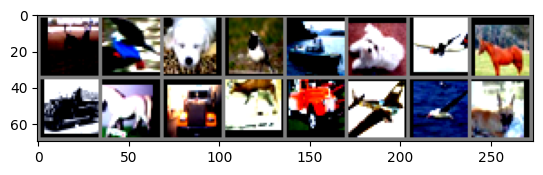

In [12]:
# Let us show some of the training images, for fun.
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

3.**Define a Convolution Neural Network**

Implement the BaseNet exactly. BaseNet consists of two convolutional modules (conv-relu-maxpool) and two linear layers. The precise architecture is defined below:

| Layer No.   | Layer Type  | Kernel Size | Input Dim   | Output Dim  | Input Channels | Output Channels |
    | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
    | 1 | conv2d | 5 | 32 | 28 | 3 | 6 |
    | 2 | relu | - | 28 | 28 | 6 | 6 |
    | 3 | maxpool2d | 2 | 28 | 14 | 6 | 6 |
    | 4 | conv2d | 5 | 14 | 10 | 6 | 16 |
    | 5 | relu | - | 10 | 10 | 16 | 16 |
    | 6 | maxpool2d | 2 | 10 | 5 | 16 | 16 |
    | 7 | linear | - | 1 | 1 | 400 | 200 |
    | 8 | relu | - | 1 | 1 | 200 | 200 |
    | 9 | linear | - | 1 | 1 | 200 | 10 |

In [13]:
########################################################################
# We provide a basic network that you should understand, run and
# eventually improve
# TODO Add more conv layers
# TODO Add more fully connected (fc) layers
# TODO Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()

        # TODO: define your model here
        self.conv1 = nn.Conv2d(3, out_channels=6, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, out_channels=16, kernel_size=5)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(16*5*5, 200)
        self.linear2 = nn.Linear(200, 10)

    def forward(self, x):

        # TODO: define your model here
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        print(x.shape)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        print(x.shape)

        x = x.view(-1, 16*5*5)
        print(x.shape)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
def randomize_net(net):
    for module in net.modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
    return net

horse  bird   dog  bird  ship   dog airplane horse truck horse truck  deer truck airplane  bird   dog


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
net = BaseNet()

In [ ]:
# Create an instance of the nn.module class defined above:
from torchvision.models import resnet34

def Residual(nn.Module):
    def __init__(self, inplanes, planes, stride, downsample=None):
        super(Residual, self).__init__()
        self.conv1 = nn.Sequential([
                nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(planes)
                nn.ReLU(inplace=True),
        ])
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Sequential([
                nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(planes)
            ])
        self.downsample = downsample
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        if self.downsample is not None:
            x += self.downsample(x)
        x = self.relu(x)
        return x
def ResNet(nn.Module):
    def __init__(self, num_classes=10, block, layers):
        super(ResNet, self).__init__()
        self.num_classes = num_classes
        self.inplanes = 64
        self.conv1 = nn.Sequential([
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(self.inplanes)
                nn.ReLU(inplace=True),
            ])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * 4, num_classes)
    def _make_layer(self, block, channels, blocks, stride=1):
        downsample = None 
        if stride != 1 or self.inplanes != channels:
            downsample = nn.Sequential([
                nn.Conv2d(self.inplanes, channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channels)
            ])
        layers.append(block(self.inplanes, channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(
                block(channels, channels)
            )
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


In [ ]:
net = ResNet(Residual, [3, 4, 6, 3])

In [ ]:
net = ResNet(Residual, [2, 2, 2, 2])
net = randomize_net(net)

In [ ]:
# Test your BaseNet with some random input
dummy_input = torch.rand((1, 3, 32, 32))
output = net(next(iter(testloader)))
# assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()

In [14]:
# TODO: paste output in your report
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

4.**Define a loss function and optimizer**

In [15]:
########################################################################
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum and weight decay is useful or not
# optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0)
optimizer = optim.Adam(net.parameters(), lr=0.00005, weight_decay=0.008)

5.**Train the model**

In [16]:
def train(net, trainloader, criterion, optimizer, epochs, decay_epochs):
    unchanged_epoch_num = 0
    train_loss_over_epochs = []
    val_accuracy_over_epochs = []
    best_acc = 0
    for epoch in tqdm(range(epochs), total=epochs):  # loop over the dataset multiple times
        if unchanged_epoch_num > decay_epochs:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * 0.1
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0

        net.train()

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            if IS_GPU:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, pred = torch.topk(outputs, 1, dim=1)
            pred = pred.squeeze()
            running_correct += (pred == labels).sum().item()
            running_total += labels.size(0)
        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)
        print(f"{optimizer.param_groups[0]['lr']:.5f}, Epoch: {epoch + 1:d}, Loss: {running_loss:.3f}, Accuracy: {100 * running_correct / running_total:.2f}%")


        # Scale of 0.0 to 100.0
        # Calculate validation set accuracy of the existing model
        net.eval()
        val_accuracy, val_classwise_accuracy = \
            calculate_accuracy(valloader, net, IS_GPU)
        print('Accuracy of the network on the val images: %d %%' % (val_accuracy))
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            unchanged_epoch_num = 0
        else:
            unchanged_epoch_num += 1
        # # Optionally print classwise accuracies
        # for c_i in range(TOTAL_CLASSES):
        #     print('Accuracy of %5s : %2d %%' % (
        #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

        train_loss_over_epochs.append(running_loss)
        val_accuracy_over_epochs.append(val_accuracy)
    # -----------------------------
    return train_loss_over_epochs, val_accuracy_over_epochs

In [ ]:
train_loss_over_epochs, val_accuracy_over_epochs = train(net, trainloader, criterion, optimizer, EPOCHS, 10)

  0%|          | 0/100 [00:00<?, ?it/s]

0.00005, Epoch: 1, Loss: 2.292, Accuracy: 23.02%
Accuracy of the network on the val images: 32 %
0.00005, Epoch: 2, Loss: 1.818, Accuracy: 33.26%
Accuracy of the network on the val images: 40 %
0.00005, Epoch: 3, Loss: 1.666, Accuracy: 39.01%
Accuracy of the network on the val images: 44 %
0.00005, Epoch: 4, Loss: 1.573, Accuracy: 42.25%
Accuracy of the network on the val images: 46 %
0.00005, Epoch: 5, Loss: 1.499, Accuracy: 45.10%
Accuracy of the network on the val images: 49 %
0.00005, Epoch: 6, Loss: 1.439, Accuracy: 47.68%
Accuracy of the network on the val images: 51 %
0.00005, Epoch: 7, Loss: 1.388, Accuracy: 49.41%
Accuracy of the network on the val images: 53 %
0.00005, Epoch: 8, Loss: 1.336, Accuracy: 51.48%
Accuracy of the network on the val images: 54 %
0.00005, Epoch: 9, Loss: 1.292, Accuracy: 53.47%
Accuracy of the network on the val images: 56 %
0.00005, Epoch: 10, Loss: 1.240, Accuracy: 55.37%
Accuracy of the network on the val images: 58 %
0.00005, Epoch: 11, Loss: 1.1

In [ ]:
train_loss_over_epochs_2, val_accuracy_over_epochs_2 = train(net, trainloader, criterion, optimizer, 20, 10)

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.00005, Epoch: 1, Loss: 0.461, Accuracy: 85.19%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 2, Loss: 0.462, Accuracy: 85.19%
Accuracy of the network on the val images: 82 %
0.00005, Epoch: 3, Loss: 0.455, Accuracy: 85.38%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 4, Loss: 0.456, Accuracy: 85.39%
Accuracy of the network on the val images: 82 %
0.00005, Epoch: 5, Loss: 0.455, Accuracy: 85.11%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 6, Loss: 0.452, Accuracy: 85.53%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 7, Loss: 0.448, Accuracy: 85.74%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 8, Loss: 0.443, Accuracy: 85.93%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 9, Loss: 0.443, Accuracy: 85.96%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 10, Loss: 0.442, Accuracy: 85.93%
Accuracy of the network on the val images: 82 %
0.00005, Epoch: 11, Loss: 0.4

In [ ]:
train_loss_over_epochs_3, val_accuracy_over_epochs_3 = train(net, trainloader, criterion, optimizer, 20, 10)


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.00005, Epoch: 1, Loss: 0.425, Accuracy: 86.45%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 2, Loss: 0.424, Accuracy: 86.54%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 3, Loss: 0.418, Accuracy: 86.52%
Accuracy of the network on the val images: 84 %
0.00005, Epoch: 4, Loss: 0.424, Accuracy: 86.60%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 5, Loss: 0.415, Accuracy: 86.67%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 6, Loss: 0.418, Accuracy: 86.73%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 7, Loss: 0.411, Accuracy: 87.05%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 8, Loss: 0.411, Accuracy: 86.93%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 9, Loss: 0.416, Accuracy: 86.79%
Accuracy of the network on the val images: 84 %
0.00005, Epoch: 10, Loss: 0.413, Accuracy: 86.81%
Accuracy of the network on the val images: 83 %
0.00005, Epoch: 11, Loss: 0.4

In [ ]:
plt.ioff()
fig = plt.figure()
EPOCHS = 60
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("mp4_q1_plot.png")
plt.close(fig)
print('Finished Training')

Finished Training


In [ ]:
net_name = "resnet18_pretrained_full_lr{}_epoch{}.pth.tar".format(5, 60)
save_path = os.path.join(work_dir, "model")
os.makedirs(save_path, exist_ok=True)
torch.save(net.state_dict(), os.path.join(save_path, net_name))

6.**Evaluate the validation accuracy of your final model**

In [ ]:
val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
print('Accuracy of the final network on the val images: %.1f %%' % (val_accuracy))

# Optionally print classwise accuracies
for c_i in range(TOTAL_CLASSES):
    print('Accuracy of %5s : %.1f %%' % (
        classes[c_i], val_classwise_accuracy[c_i]))


Accuracy of the final network on the val images: 65.5 %
Accuracy of airplane : 71.3 %
Accuracy of automobile : 80.9 %
Accuracy of  bird : 52.8 %
Accuracy of   cat : 45.9 %
Accuracy of  deer : 50.9 %
Accuracy of   dog : 60.8 %
Accuracy of  frog : 82.4 %
Accuracy of horse : 65.9 %
Accuracy of  ship : 75.5 %
Accuracy of truck : 68.4 %


7.**Visualize test set images**

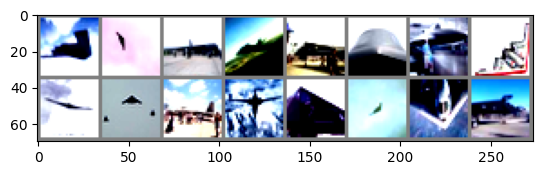

In [ ]:
# get some random training images
dataiter = iter(testloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

8.**Evaluate your final model on the test set**

Submit `predictions.npy` to Gradescope to see your model's performance on the test set.

In [ ]:
# run inference on the test set
predictions = run_secret_test(testloader, net, IS_GPU)
# save predictions
predictions = np.asarray(predictions)
np.save("Q1_label_predictions.npy", predictions)